In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

def exp_func(x, a, b, c):
    return -a*np.exp(-b*x) + c
def exp_func2(x, a, b, c, d):
    return a*np.exp(b*(x-c)) + d
def saturation_cuve(t, tau, a0):
    return a0*(1 - np.exp(-t / tau))
def stretched_saturation_curve(t, tau, a0, beta):
    return a0*(1 - np.exp(-((t/tau)**beta)))
def double_saturation_cuve(t, tau1, tau2, a0, b0, b1):
    return a0 - b0* np.exp(-t / tau1) - b1* np.exp(-t / tau2)
def lin_func(x, a, b, c):
    return a*(x-b)+c
def pot_law(x, a, b):
    return a*x**b

## String Plot

In [5]:
topology_parameter  = {
    "Nx"                : 11,
    "Ny"                : 1,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0],[10,0,0]],
    "electrode_type"    : ['constant','constant']
}
sim_class   = nanonets.simulation(topology_parameter, high_C_output=True)
print(sim_class)
# fig, ax     = plt.subplots(dpi=200)
# fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=80)

# fig.savefig("../plots/string_network.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/string_network.pdf", transparent=False, bbox_inches='tight')

Topology Class with 12 particles, 3 junctions.
Network Topology:
[[   1    1 -100 -100]
 [-100    0    2 -100]
 [-100    1    3 -100]
 [-100    2    4 -100]
 [-100    3    5 -100]
 [-100    4    6 -100]
 [-100    5    7 -100]
 [-100    6    8 -100]
 [-100    7    9 -100]
 [-100    8   10 -100]
 [-100    9   11 -100]
 [   2   10 -100 -100]]


## DC Input - Voltage Distribution - Closed Circuit

In [5]:
folder_cold = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
folder_hot  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
# folder_cold = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
# folder_hot  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
U_0_cold    = 0.02
U_0_hot     = 1.0
t_vals      = np.arange(39999)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20]
pot_cold    = {N_p : pd.read_csv(f"{folder_cold}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_hot     = {N_p : pd.read_csv(f"{folder_hot}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq_cold = pd.DataFrame([pot_cold[N_p].iloc[30000:,:].mean().values / U_0_cold for N_p in N_vals],index=N_vals).T.round(2)
pot_eq_hot  = pd.DataFrame([pot_hot[N_p].iloc[30000:,:].mean().values / U_0_hot for N_p in N_vals],index=N_vals).T.round(2)

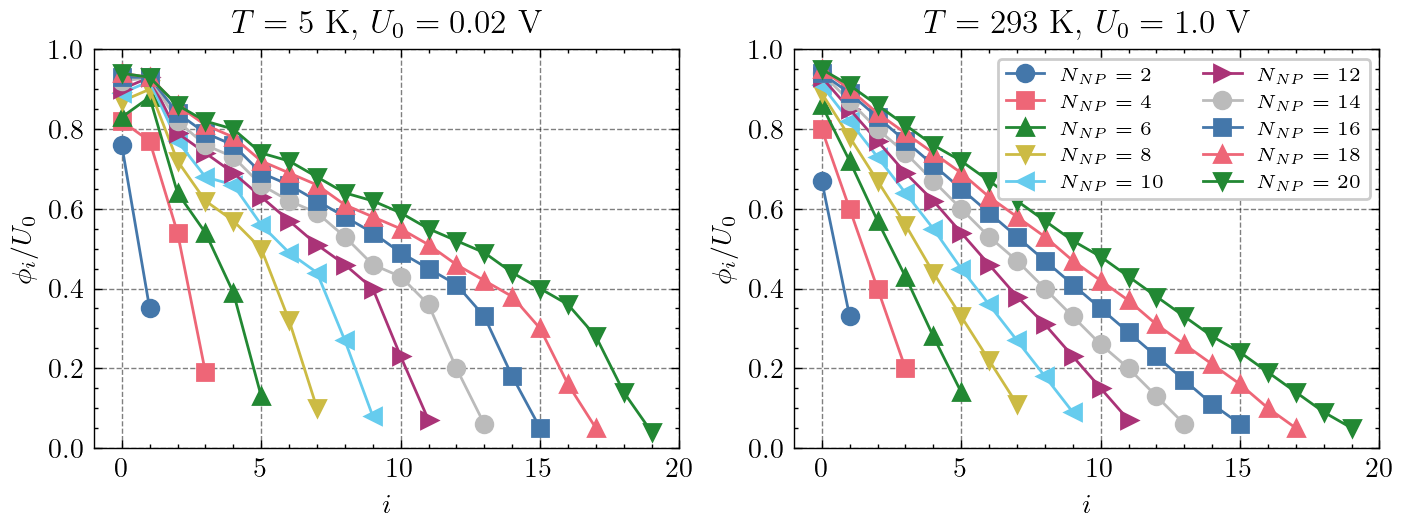

In [43]:
ma  = ["o","s","^","v","<",">"]
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):
    ax1.plot(pot_eq_cold[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")
    ax2.plot(pot_eq_hot[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax1.set_xlim(-1,20)
ax2.set_xlim(-1,20)
ax1.set_ylabel("$\phi_i / U_0$")
ax2.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/closed_circuit_node_potential_vs_T.svg", transparent=True)

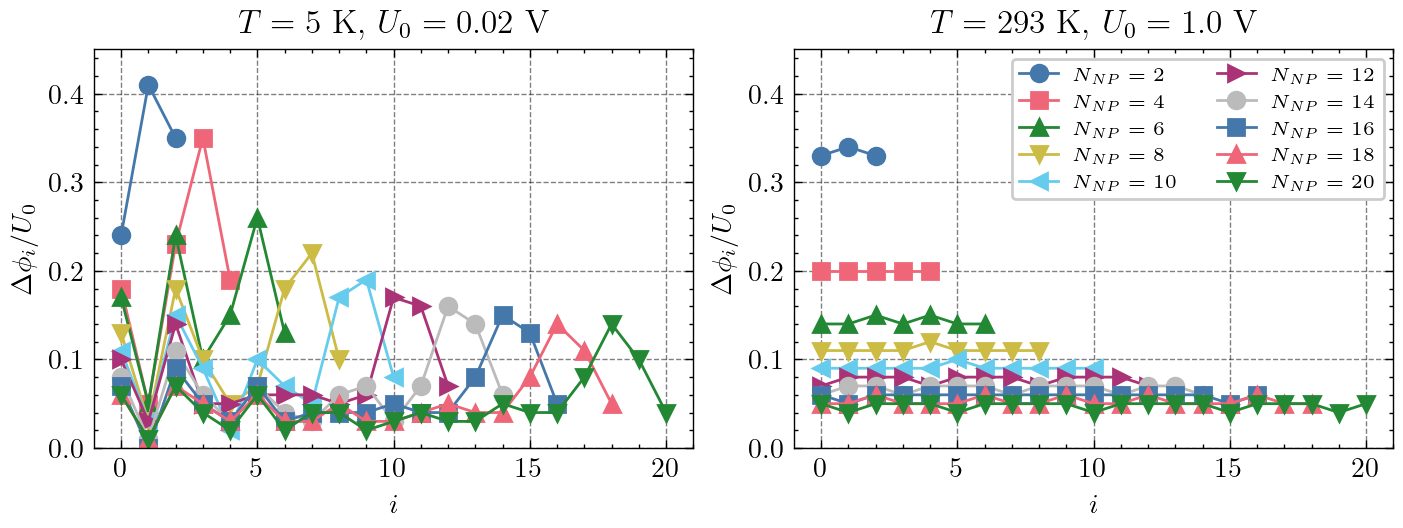

In [44]:
ma  = ["o","s","^","v","<",">"]
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):

    arr_cold    = np.insert(pot_eq_cold[N].dropna().values*U_0_cold, 0, U_0_cold)
    arr_cold    = np.append(arr_cold, 0.0)
    arr_cold    = np.diff(arr_cold)

    arr_hot = np.insert(pot_eq_hot[N].dropna().values*U_0_hot, 0, U_0_hot)
    arr_hot = np.append(arr_hot, 0.0)
    arr_hot = np.diff(arr_hot)

    ax1.plot(np.abs(arr_cold)/U_0_cold, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")
    ax2.plot(np.abs(arr_hot)/U_0_hot, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlim(-1,21)
ax2.set_xlim(-1,21)
ax1.set_ylim(0, 0.45)
ax2.set_ylim(0, 0.45)
ax1.set_ylabel("$\Delta \phi_i / U_0$")
ax2.set_ylabel("$\Delta \phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/closed_circuit_node_potential_difference_vs_T.svg", transparent=True)

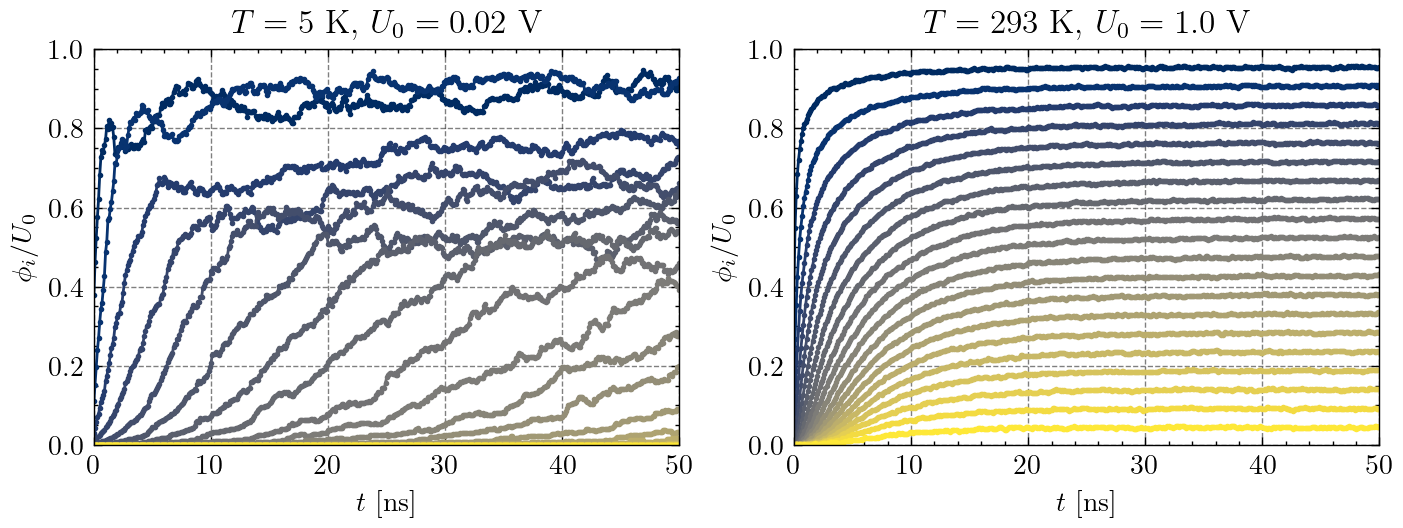

In [45]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in range(Np):
    ax1.plot(t_vals, pot_cold[Np][f"{i}"].values/U_0_cold, color=cm((i)/Np), marker='.', ms=2)
    p = ax2.plot(t_vals, pot_hot[Np][f"{i}"].values/U_0_hot, color=cm((i)/Np), marker='.', ms=2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(0,50)
ax2.set_xlim(0,50)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax1.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$\phi_i / U_0$")
ax2.set_xlabel("$t$ [ns]")

fig.savefig("../plots/dc_input/closed_circuit_node_time_series_vs_T.svg", transparent=True)

In [46]:
def double_saturation_cuve(t, tau1, tau2, a0, b0, b1):
    return a0 - b0* np.exp(-t / tau1) - b1* np.exp(-t / tau2)

[0.15276812 0.95501036 0.34482628]
[0.70423985 0.90733195 0.47521464]
[1.45725533 0.85941575 0.58358987]
[2.2817705  0.81149467 0.68271457]
[3.12476821 0.76357451 0.77464353]
[3.94657129 0.71565494 0.86641656]
[4.73116817 0.66770147 0.95552828]


/tmp/ipykernel_28896/1570286395.py:20: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-((t/tau)**beta)))


[5.44995508 0.61976391 1.04384804]
[6.12565331 0.57182923 1.12465993]
[6.70736551 0.52391228 1.20302524]
[7.25058726 0.47599828 1.28024445]
[7.75490626 0.42806838 1.35855973]
[8.1858164  0.38014755 1.41768728]
[8.53101777 0.33223416 1.48041477]
[8.82488362 0.28433418 1.5370341 ]
[9.09644099 0.23641019 1.59421329]
[9.36195134 0.18847925 1.62973121]
[9.56994353 0.14057032 1.6501707 ]
[9.62058807 0.09268148 1.68722896]
[9.78479617 0.04499629 1.71761571]


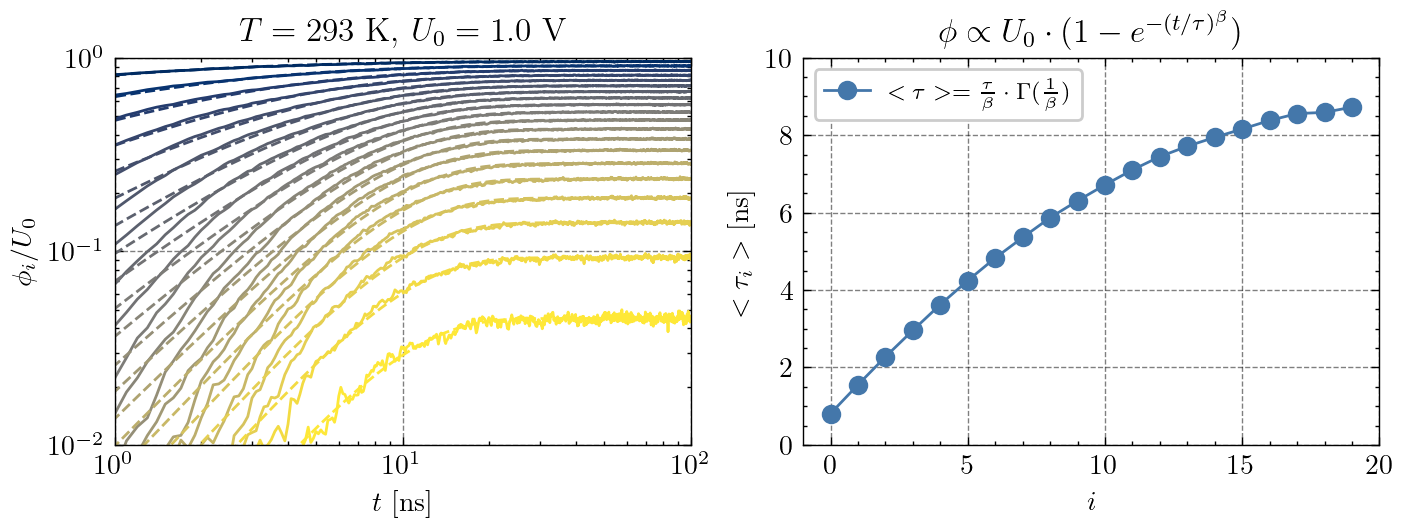

In [48]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax      = fig.add_subplot(1,2,1)
cm      = plt.get_cmap('cividis')
taus    = []
taus1   = []
taus2   = []
betas   = []
start   = 1

for i in range(Np):
    x, y    = t_vals[start:], pot_hot[Np][f"{i}"].values[start:]/U_0_hot
    p,c     = curve_fit(stretched_saturation_curve, x, y, maxfev=10000)#, p0=[1,5,1.0,0.0,0.0], bounds=[(0,0,0,0,0),(10,10,1,2,2)])
    taus.append(p[0])
    taus1.append(p[0])
    taus2.append(p[1])
    betas.append(p[2])
    print(p)

    ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
    ax.plot(x, stretched_saturation_curve(x, *p), color=cm((i+1)/Np), ls='--')

tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
ax.set_xlim(1,100)
# ax.set_ylim(0.001,1)
ax.set_ylim(0.01,1)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

ax  = fig.add_subplot(1,2,2)
ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
ax.set_ylabel('$<\\tau_i>$ [ns]')
ax.set_xlabel("$i$")
ax.set_ylim(0,10)
ax.set_xlim(-1,20)
ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
ax.legend(fontsize='small')

fig.savefig("../plots/dc_input/closed_circuit_room_temp_fit.svg", transparent=True)

## DC Input - Voltage Distribution - Open Circuit

In [3]:
# folder_cold = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
# folder_hot  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
folder_cold = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size//"
folder_hot  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
U_0_cold    = 0.02
U_0_hot     = 1.0
t_vals      = np.arange(39999)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20]
pot_cold    = {N_p : pd.read_csv(f"{folder_cold}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_hot     = {N_p : pd.read_csv(f"{folder_hot}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq_cold = pd.DataFrame([pot_cold[N_p].iloc[30000:,:].mean().values / U_0_cold for N_p in N_vals],index=N_vals).T.round(2)
pot_eq_hot  = pd.DataFrame([pot_hot[N_p].iloc[30000:,:].mean().values / U_0_hot for N_p in N_vals],index=N_vals).T.round(2)

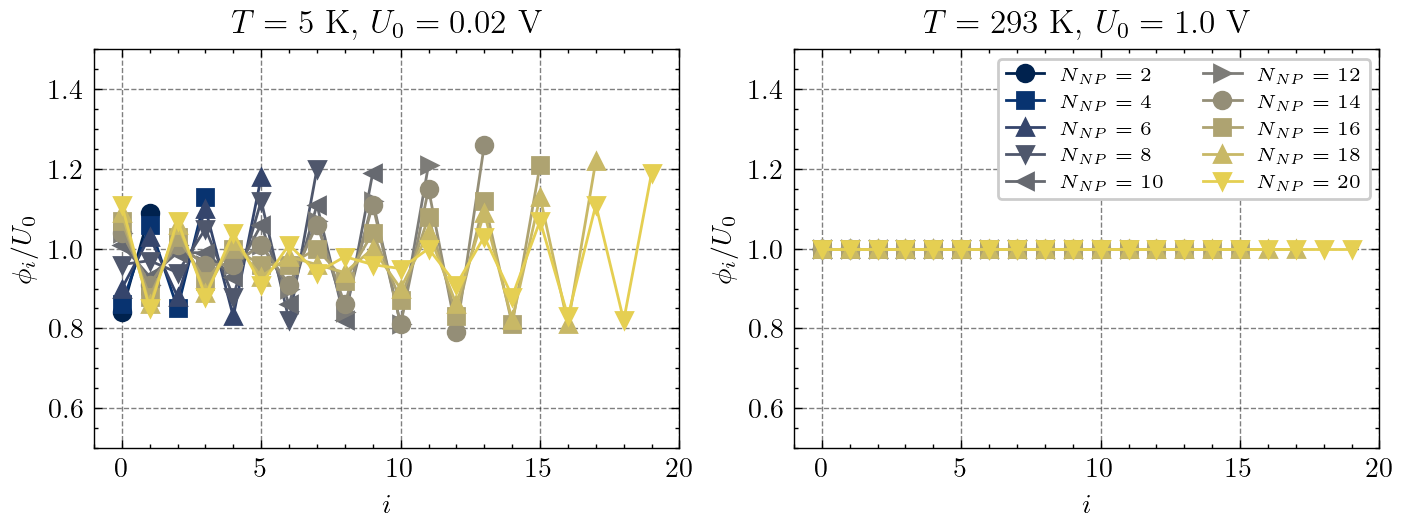

In [30]:
ma  = ["o","s","^","v","<",">"]
cm  = plt.get_cmap('cividis')
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):
    ax1.plot(pot_eq_cold[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))
    ax2.plot(pot_eq_hot[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_ylim(0.5,1.5)
ax2.set_ylim(0.5,1.5)
ax1.set_xlim(-1,20)
ax2.set_xlim(-1,20)
ax1.set_ylabel("$\phi_i / U_0$")
ax2.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/open_circuit_node_potential_vs_T.svg", transparent=True)

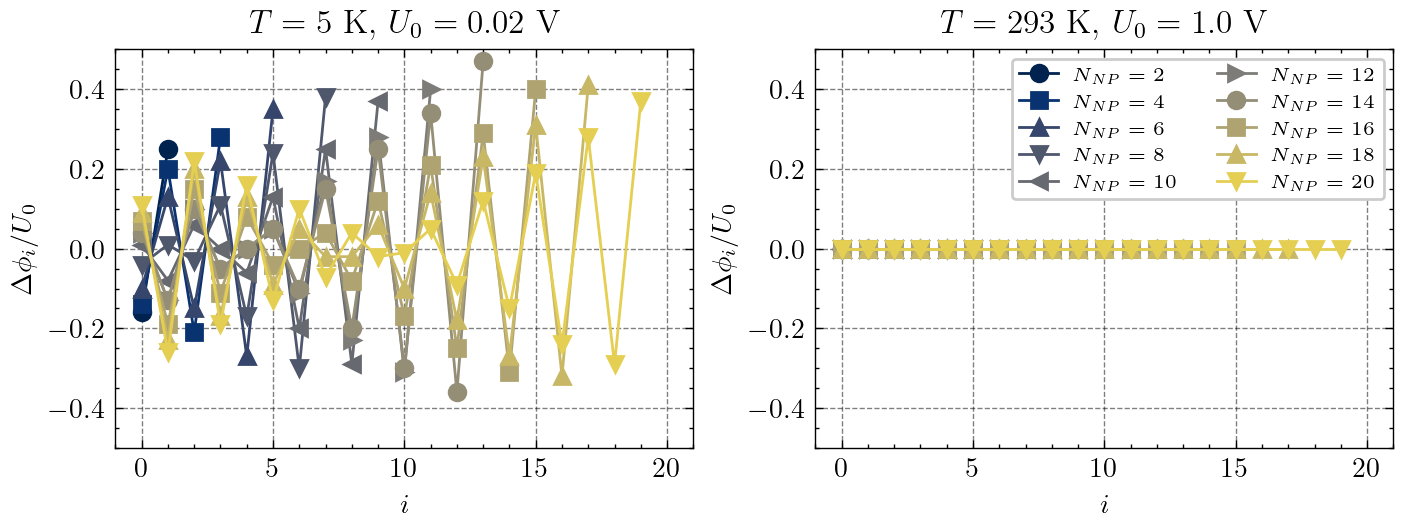

In [29]:
ma  = ["o","s","^","v","<",">"]
cm  = plt.get_cmap('cividis')
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):

    arr_cold    = np.insert(pot_eq_cold[N].dropna().values*U_0_cold, 0, U_0_cold)
    arr_cold    = np.diff(arr_cold)

    arr_hot = np.insert(pot_eq_hot[N].dropna().values*U_0_hot, 0, U_0_hot)
    arr_hot = np.diff(arr_hot)

    ax1.plot(arr_cold/U_0_cold, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))
    ax2.plot(arr_hot/U_0_hot, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlim(-1,21)
ax2.set_xlim(-1,21)
ax1.set_ylim(-0.5, 0.5)
ax2.set_ylim(-0.5, 0.5)
ax1.set_ylabel("$\Delta \phi_i / U_0$")
ax2.set_ylabel("$\Delta \phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/open_circuit_node_potential_difference_vs_T.svg", transparent=True)

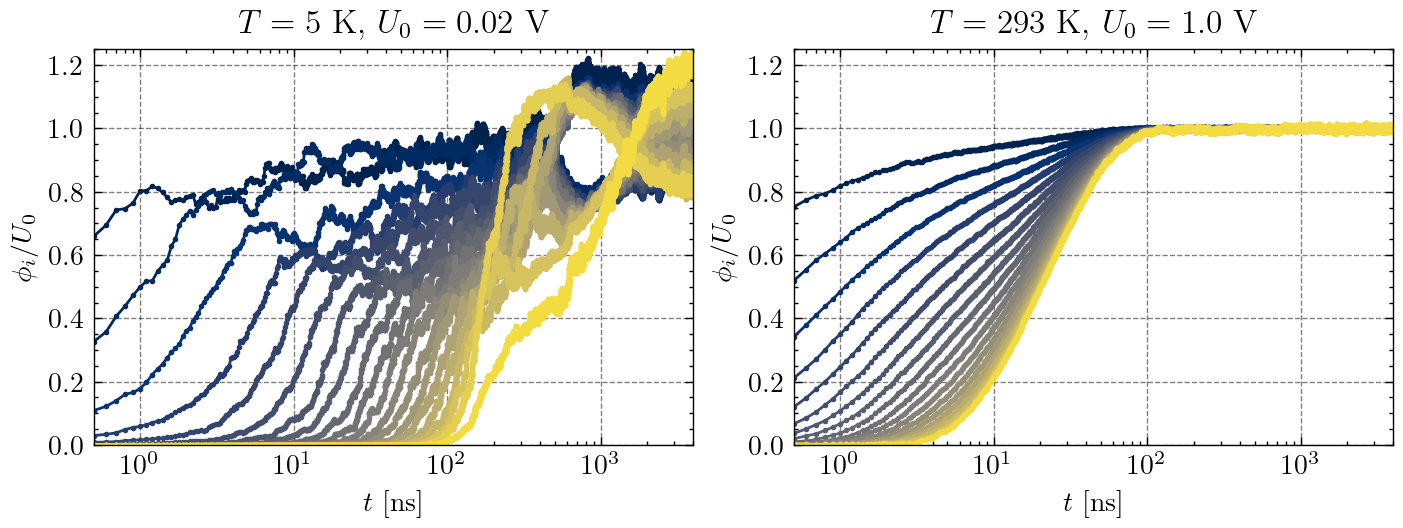

In [171]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in range(Np):
    ax1.plot(t_vals, pot_cold[Np][f"{i}"].values/U_0_cold, color=cm((i)/Np), marker='.', ms=2)
    p = ax2.plot(t_vals, pot_hot[Np][f"{i}"].values/U_0_hot, color=cm((i)/Np), marker='.', ms=2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(0.5,4000)
ax2.set_xlim(0.5,4000)
ax1.set_ylim(0,1.25)
ax2.set_ylim(0,1.25)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$\phi_i / U_0$")
ax2.set_xlabel("$t$ [ns]")

fig.savefig("../plots/dc_input/open_circuit_node_time_series_vs_T.svg", transparent=True)

In [149]:
def exp_saturation(x, tau, a0, x0):
    return a0*(1 - np.exp(-(x-x0)/tau))
def stretched_exp_saturation(x, tau, beta, a0):
    return a0*(1 - np.exp(-(x/tau)**beta))
def power_law_saturation(x, tau, beta, a0):
    return a0*(1 - (x/tau)**(-beta))
def double_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1 - np.exp(-x/tau1)) + a2*(1 - np.exp(-x/tau2))
def hyperbolic_saturation(x, tau, a0):
    return a0*(1 - 1/(1+x/tau))
def log_saturation(x, tau, a0):
    return a0*(1 - 1/np.log(1+x/tau))
def modified_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1-np.exp(-x/tau1)) + a2*np.exp(-x/tau2)
def logistic_function(x, tau, a0, x0):
    return a0 / (1 + np.exp(-(x-x0)/tau))
def generalized_logistic_function(x, tau, a0, x0, nu1, nu2):
    return a0 / ((1 + nu1*np.exp(-(x-x0)/tau))**(1/nu2))
def exp_power_law_saturation(x, tau1, tau2, beta, a0):
    return a0*(1 - np.exp(-x/tau1)/(1 + (x/tau2)**(-beta)))

/tmp/ipykernel_23684/3132988767.py:4: RuntimeWarning: divide by zero encountered in power
  return a0*(1 - np.exp(-(x/tau)**beta))
/tmp/ipykernel_23684/3132988767.py:4: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-(x/tau)**beta))


[0.12957498 0.23343771 1.00795276]
[1.05146356 0.3177248  1.0129812 ]
[2.84003042 0.38692333 1.01822659]
[5.16188348 0.45406527 1.02065146]
[7.75834573 0.52081515 1.02186951]
[10.38578369  0.58852048  1.02133127]
[12.87601957  0.65862339  1.01886858]
[15.12710336  0.73104992  1.01485636]
[17.11097237  0.80505662  1.00967415]
[18.9435646   0.8768283   1.00540184]
[20.52592514  0.94764286  1.00081889]
[21.89989811  1.01666387  0.99637266]
[23.09190918  1.08362149  0.99223785]
[24.09488336  1.14447459  0.9887271 ]
[24.93648848  1.20017919  0.98543234]
[25.6471071   1.24582845  0.98303559]
[26.19846369  1.28708324  0.98079759]
[26.60276463  1.31695949  0.97946256]
[26.85620183  1.33694603  0.97828255]
[27.00496184  1.34630467  0.97781887]


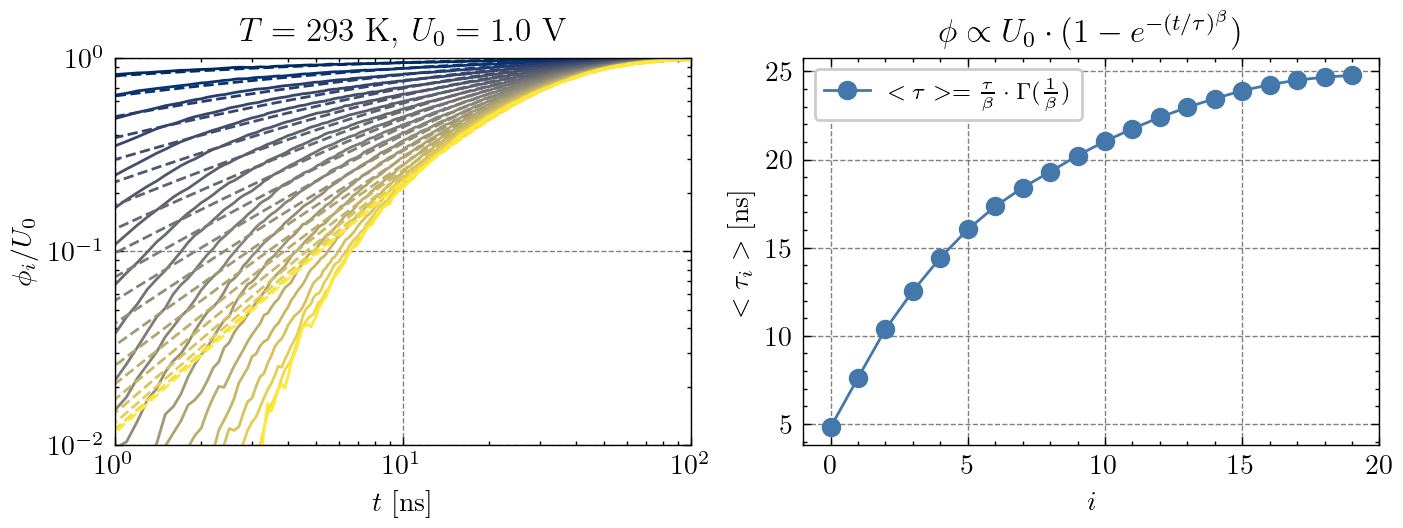

In [158]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax      = fig.add_subplot(1,2,1)
cm      = plt.get_cmap('cividis')
func    = stretched_exp_saturation
taus    = []
taus1   = []
taus2   = []
betas   = []
starts  = np.round(np.linspace(0,0,Np))
stop    = 1000

for i in range(Np):
    x, y    = t_vals[int(starts[i]):stop], pot_hot[Np][f"{i}"].values[int(starts[i]):stop]/U_0_hot
    p,c     = curve_fit(func, x, y, maxfev=10000, p0=[10, 2, 1])#, 0], bounds=[(0,0,0,0),(100,1,2,100)])
    taus.append(p[0])
    taus1.append(p[0])
    taus2.append(p[1])
    betas.append(p[1])
    print(p)
    ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
    ax.plot(x, func(x, *p), color=cm((i+1)/Np), ls='--')
    

tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
ax.set_xlim(1,100)
ax.set_ylim(0.01,1)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

ax  = fig.add_subplot(1,2,2)
ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
ax.set_ylabel('$<\\tau_i>$ [ns]')
ax.set_xlabel("$i$")
# ax.set_ylim(0,10)
ax.set_xlim(-1,20)
ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
ax.legend(fontsize='small')

fig.savefig("../plots/dc_input/open_circuit_room_temp_fit.svg", transparent=True)

In [416]:
current_cold    = {N_p : pd.read_csv(f"{folder_cold}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
current_hot     = {N_p : pd.read_csv(f"{folder_hot}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}

Text(0.5, 0, '$t$ [ns]')

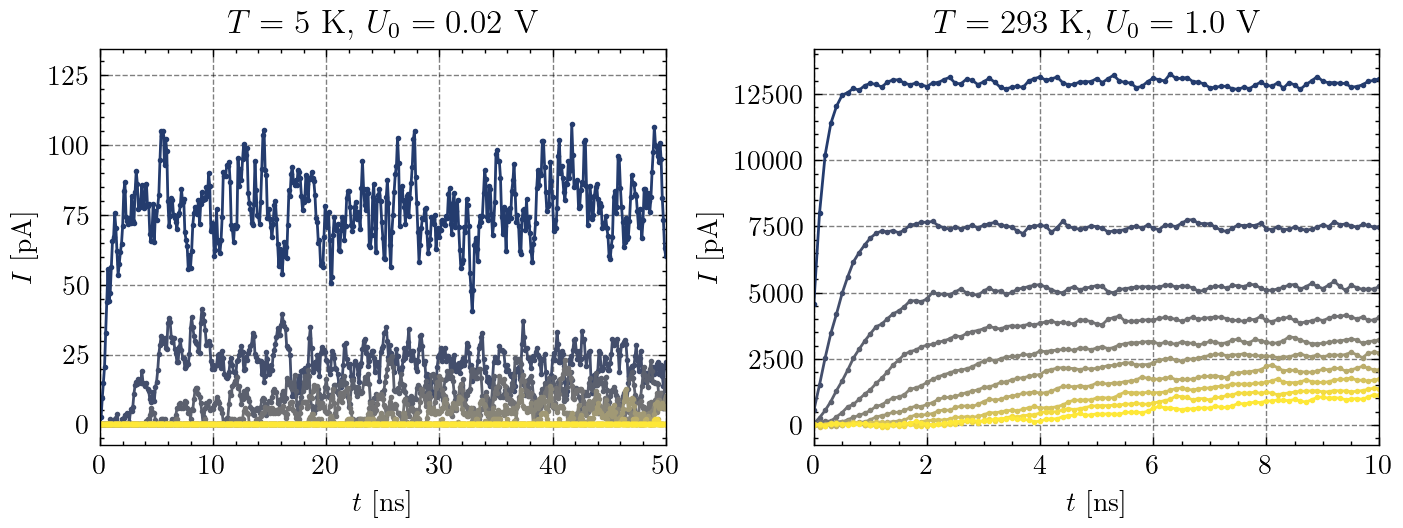

In [436]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in N_vals:
    ax1.plot(t_vals, current_cold[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
    p = ax2.plot(t_vals, current_hot[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(0,50)
ax2.set_xlim(0,10)
# ax1.set_ylim(0.0001,10000)
# ax2.set_ylim(10,100000)
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_ylabel("$I$ [pA]")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$I$ [pA]")
ax2.set_xlabel("$t$ [ns]")

(0.1, 10.0)

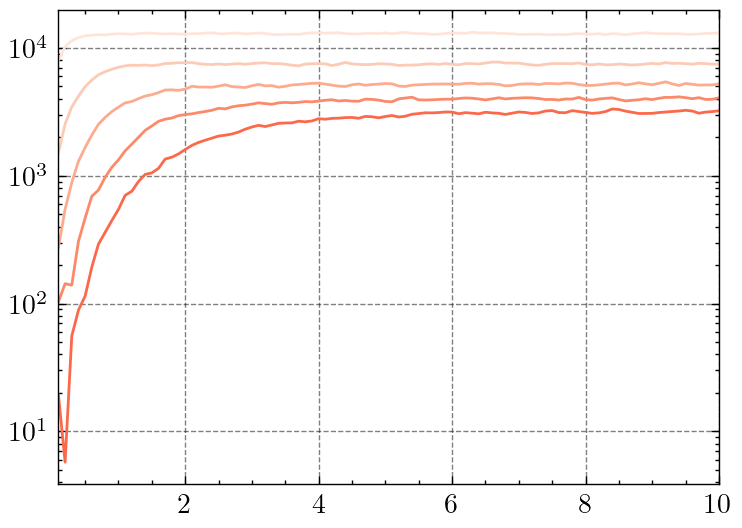

In [161]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals[:-5]):

    y_val   = data_string[N]['Current'].values
    y_val_e = data_string[N]['Error'].values
    ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i+1)/len(N_vals)))
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0.1,10)

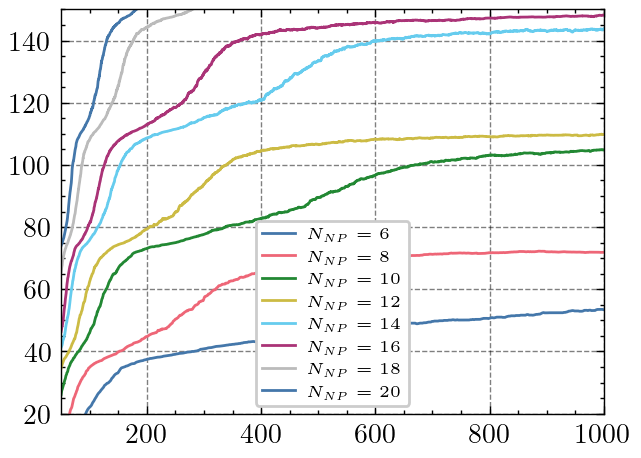

In [4]:
taus    = [21,10.4,5.6,3.5,2.4,1.8,1.3,1]
p, c    = curve_fit(pot_law, np.array(N_vals[2:]), taus)

plt.figure(dpi=200)
for i, N in enumerate(N_vals[2:]):
    plt.plot(t_vals*taus[i], data_string[N]['Current'].values*1000, label='$N_{NP} = '+f'{N}$')

plt.xlim(50,1000)
plt.ylim(20,150)
plt.legend(fontsize='xx-small')

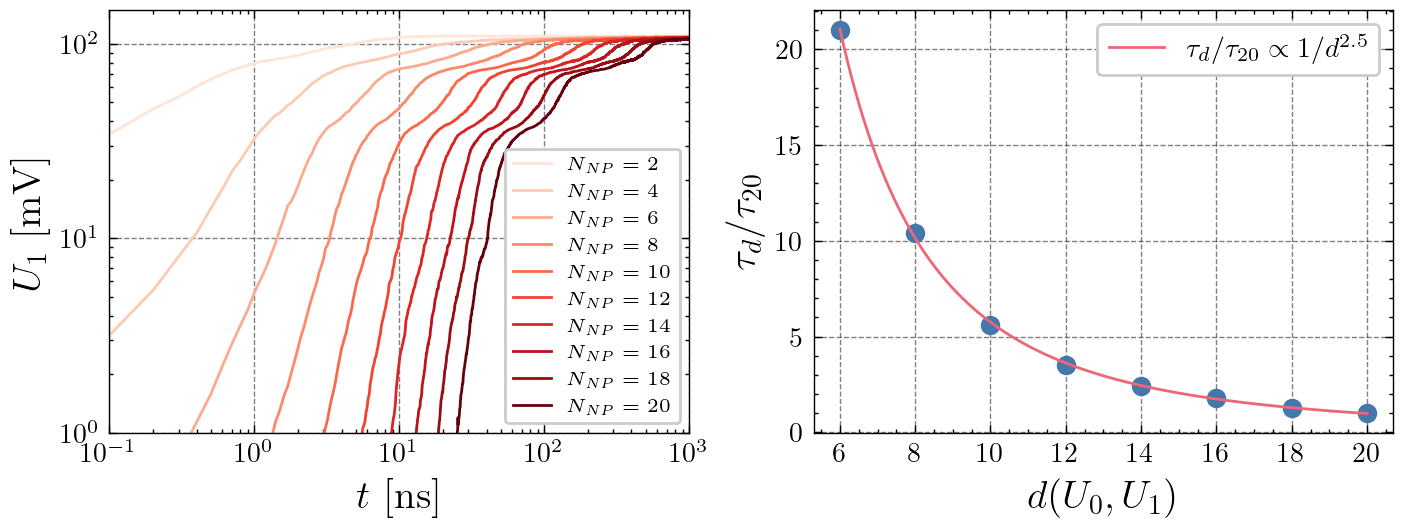

In [18]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i+1)/len(N_vals)))

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,1000)
ax.set_xscale('log')
ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals[2:]), taus, 'o')
ax.plot(np.linspace(N_vals[2],N_vals[-1],1000), func(np.linspace(N_vals[2],N_vals[-1],1000),*p), label="$\\tau_d / \\tau_{20} \propto 1/d^{"+f"{-np.round(p[1],1)}"+"}$")
ax.set_ylabel("$\\tau_{d} / \\tau_{20}$", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals[2:])
ax.legend()

fig.savefig("../plots/string_time_scale_vs_system_size.svg", transparent=True)
fig.savefig("../plots/string_time_scale_vs_system_size.pdf", transparent=False)

In [6]:
taus    = []
tau_m   = []
params  = []
covs    = []

for i, N in enumerate(N_vals):
    x_fit   = t_vals.copy()
    y_fit   = data_string[N]['Current'].values*1000
    # p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,0,0),(500,120,2)])
    p, cov  = curve_fit(saturation_cuve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,80,0),(500,120,20)])
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    tau_m.append(p[0]/p[2] * gamma(1 / p[2]))
    
params

[array([1.60015509e+00, 1.03222185e+02, 3.38248978e-18]),
 array([6.87494356e+00, 1.06505458e+02, 1.86541772e-15]),
 array([1.61888535e+01, 1.03320463e+02, 5.62083227e-19]),
 array([3.42083950e+01, 1.03001236e+02, 1.36004593e-23]),
 array([6.47660070e+01, 1.03127269e+02, 3.62676747e-25]),
 array([1.01835044e+02, 1.02259691e+02, 1.91749288e-26]),
 array([1.48732338e+02, 1.01774407e+02, 3.12229083e-25]),
 array([2.06097830e+02, 1.01184761e+02, 5.32583098e-26]),
 array([2.74897536e+02, 1.00287984e+02, 3.72935542e-24]),
 array([3.43525165e+02, 9.91502037e+01, 2.69950599e-23])]

ValueError: x and y must have same first dimension, but have shapes (10,) and (8,)

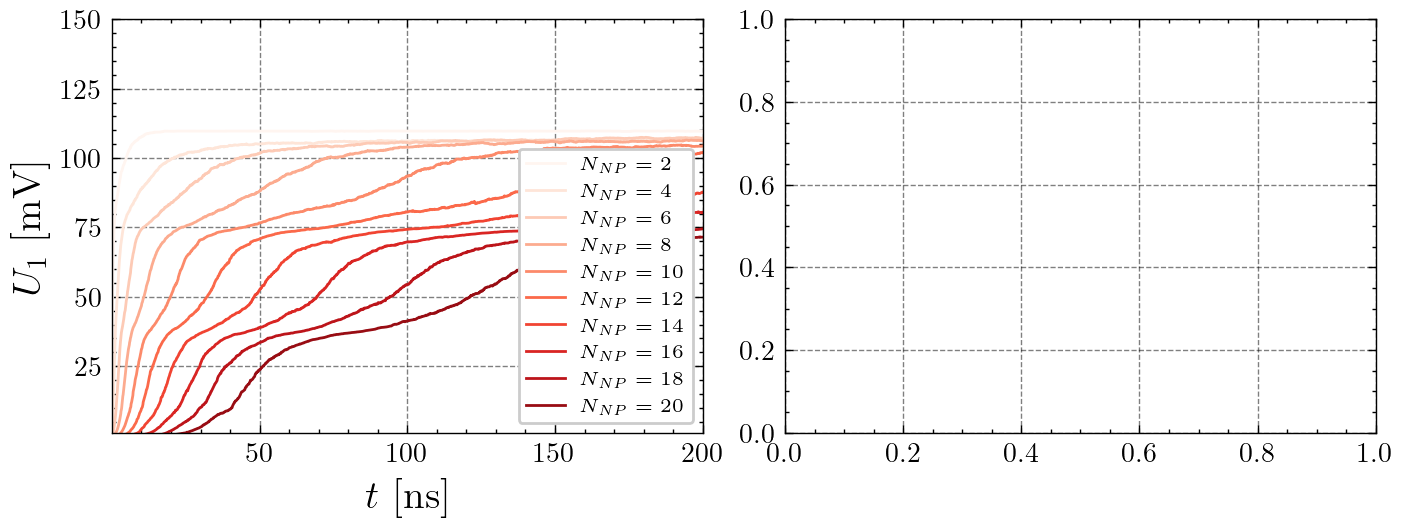

In [124]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i)/len(N_vals)))
    # pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', marker=ms[i%len(ms)], markevery=(20,100), ls='')
    # ax.plot(t_vals, stretched_saturation_curve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.plot(t_vals, saturation_cuve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,200)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, 'o')
ax.plot(np.array(N_vals), 0.26*np.array(N_vals)**2.4)
ax.set_ylabel("$\\tau$ [ns]", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals)
# ax.set_ylim(0,40)
ax.set_xscale('log')
ax.set_yscale('log')

# fig.savefig("../plots/string_time_scale_vs_system_size.svg", transparent=True)
# fig.savefig("../plots/string_time_scale_vs_system_size.pdf", transparent=False)

## @ 293K

In [32]:
taus    = []
tau_m   = []
params  = []
covs    = []

for i, N in enumerate(N_vals):
    x_fit   = t_vals.copy()
    y_fit   = data_string[N]['Current'].values*1000
    # p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,0,0),(500,120,2)])
    p, cov  = curve_fit(saturation_cuve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,80,0),(500,120,20)])
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    tau_m.append(p[0]/p[2] * gamma(1 / p[2]))
    
params

[array([3.60208636e-01, 9.99983951e+01, 2.70140781e-14]),
 array([1.30473252e+00, 1.00080876e+02, 1.38410236e-02]),
 array([ 2.31365925, 99.89964599,  0.18774591]),
 array([ 4.24694063, 99.9524589 ,  0.42656966]),
 array([  5.82758871, 100.23118775,   1.00917875]),
 array([ 7.42061568, 99.90728945,  1.56537125]),
 array([ 14.41197854, 100.14512246,   1.23286686]),
 array([13.72309518, 99.75983272,  2.30518612]),
 array([ 18.2560149 , 100.21237258,   1.99005654]),
 array([25.19781029, 99.76907112,  3.68441668])]

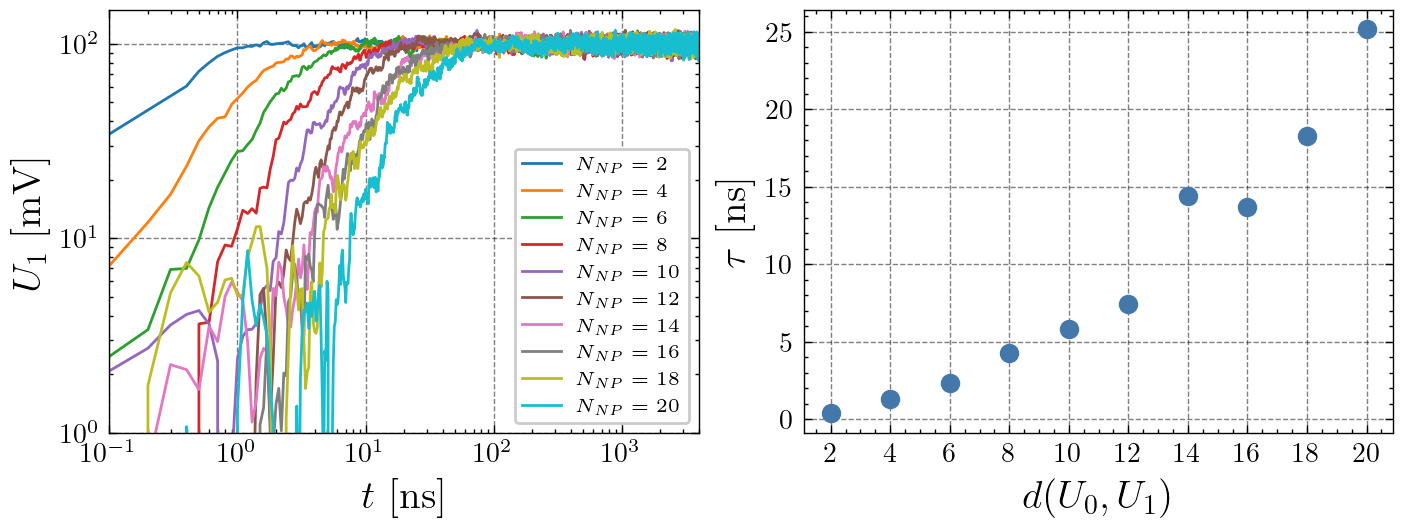

In [35]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('tab20')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i)/len(N_vals)))
    # pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', marker=ms[i%len(ms)], markevery=(20,100), ls='')
    # ax.plot(t_vals, stretched_saturation_curve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.plot(t_vals, saturation_cuve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,4000)
ax.set_xscale('log')
ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, 'o')
ax.set_ylabel("$\\tau$ [ns]", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals)

fig.savefig("../plots/string_time_scale_vs_system_size_room_temp.svg", transparent=True)
fig.savefig("../plots/string_time_scale_vs_system_size_room_temp.pdf", transparent=False)

In [1]:
path    = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/time_scale/"
N_vals  = [3,5,7,9,11,13]
data    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8.csv") for N in N_vals}
states  = pd.read_csv(f"{path}mean_state_Nx=11_Ny=11_Nz=1_Ne=8.csv")
x_val   = data[5]['E0'].values*1000
t_val   = np.arange(len(x_val))*1e-10*1e9

NameError: name 'pd' is not defined

In [195]:
taus    = []
params  = []
covs    = []
starts  = len(N_vals)*[0]
stops   = len(N_vals)*[5000]

for i, N in enumerate(N_vals):
    x_fit   = t_vals[starts[i]:stops[i]]
    y_fit   = data[N]['Current'].values[starts[i]:stops[i]]*1000
    p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,20,0], bounds=((0,0,0),(200,30,2)))
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    
params

[array([ 1.81094987, 10.22819503,  0.80748377]),
 array([3.63031915, 8.29002692, 1.15052751]),
 array([10.64988641,  9.33251991,  1.09799198]),
 array([29.63764537, 13.22357227,  1.17027035]),
 array([68.81264448, 25.9804675 ,  1.82999042]),
 array([128.50547546,  27.69472734,   1.53167537])]

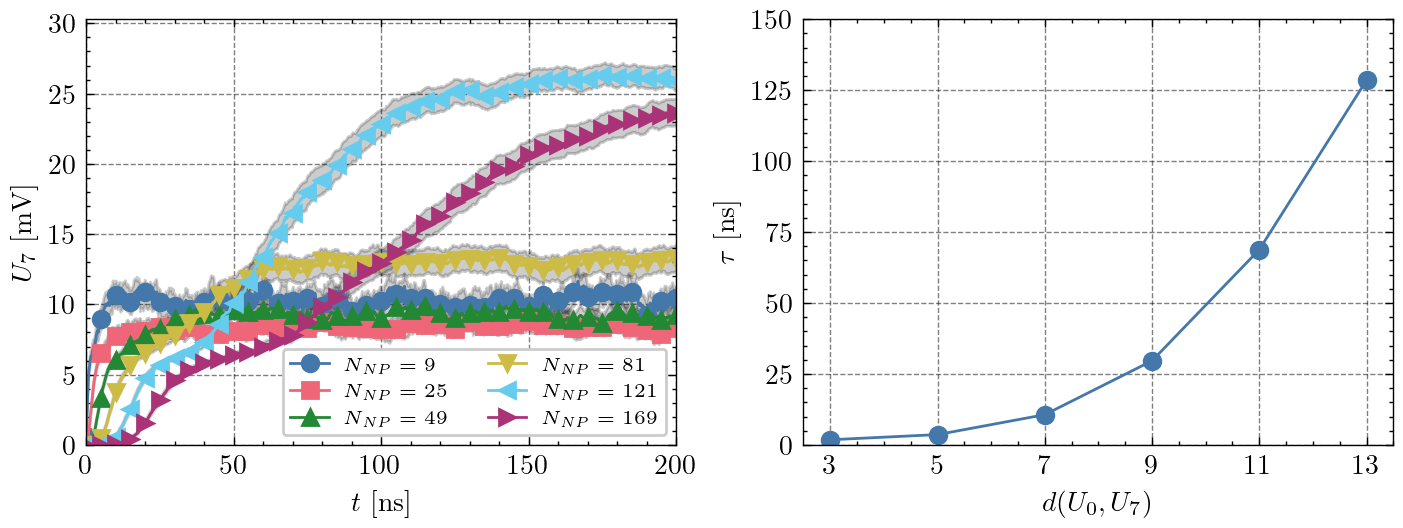

In [200]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']

for i, N in enumerate(N_vals):

    y_val   = data[N]['Current'].values*1000
    y_val_e = data[N]['Error'].values*1000
    ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N**2}$', marker=ms[i%len(ms)], markevery=(50))
    ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_7$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=2)
ax.set_xlim(0,200)
ax.set_ylim(0)

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, '-o')
ax.set_ylabel("$\\tau$ [ns]")
ax.set_xlabel("$d(U_0,U_7)$")
ax.set_xticks(N_vals)
ax.set_ylim(0,150)

fig.savefig("../plots/network_time_scale_vs_system_size.svg", transparent=True)
fig.savefig("../plots/network_time_scale_vs_system_size.pdf", transparent=False)

In [214]:
[i*11+11//2 for i in range(11)] + [121]

[5, 16, 27, 38, 49, 60, 71, 82, 93, 104, 115, 121]

In [213]:
11*11

121

In [218]:
states_string

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.045312,0.015904,0.004412,0.001203,0.000328,0.000089,0.000024,0.000007,0.000002,4.936670e-07,1.347624e-07,3.742445e-08,1.272531e-08
1,0.057602,0.026976,0.008983,0.002496,0.000680,0.000185,0.000051,0.000014,0.000004,1.024357e-06,2.796315e-07,7.765559e-08,2.640497e-08
2,0.065364,0.034964,0.014120,0.004286,0.001168,0.000318,0.000087,0.000024,0.000006,1.758922e-06,4.801547e-07,1.333423e-07,4.533993e-08
3,0.070252,0.040504,0.019233,0.006894,0.001949,0.000531,0.000145,0.000039,0.000011,2.934340e-06,8.010234e-07,2.224497e-07,7.563884e-08
4,0.072698,0.045456,0.023894,0.009730,0.002951,0.000805,0.000219,0.000060,0.000016,4.443235e-06,1.212925e-06,3.368377e-07,1.145338e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.102055,0.087345,0.098696,0.086763,0.097898,0.086491,0.093324,0.086367,0.083075,9.727145e-02,8.570426e-02,9.701321e-02,8.177111e-02
4995,0.102055,0.087345,0.098696,0.086763,0.097898,0.086491,0.093324,0.086367,0.083075,9.727145e-02,8.570426e-02,9.701321e-02,8.177111e-02
4996,0.102055,0.087343,0.098688,0.086732,0.097928,0.086499,0.093326,0.086367,0.083076,9.727150e-02,8.570427e-02,9.701322e-02,8.177111e-02
4997,0.102055,0.087343,0.098688,0.086732,0.097928,0.086499,0.093326,0.086367,0.083076,9.727150e-02,8.570427e-02,9.701322e-02,8.177111e-02


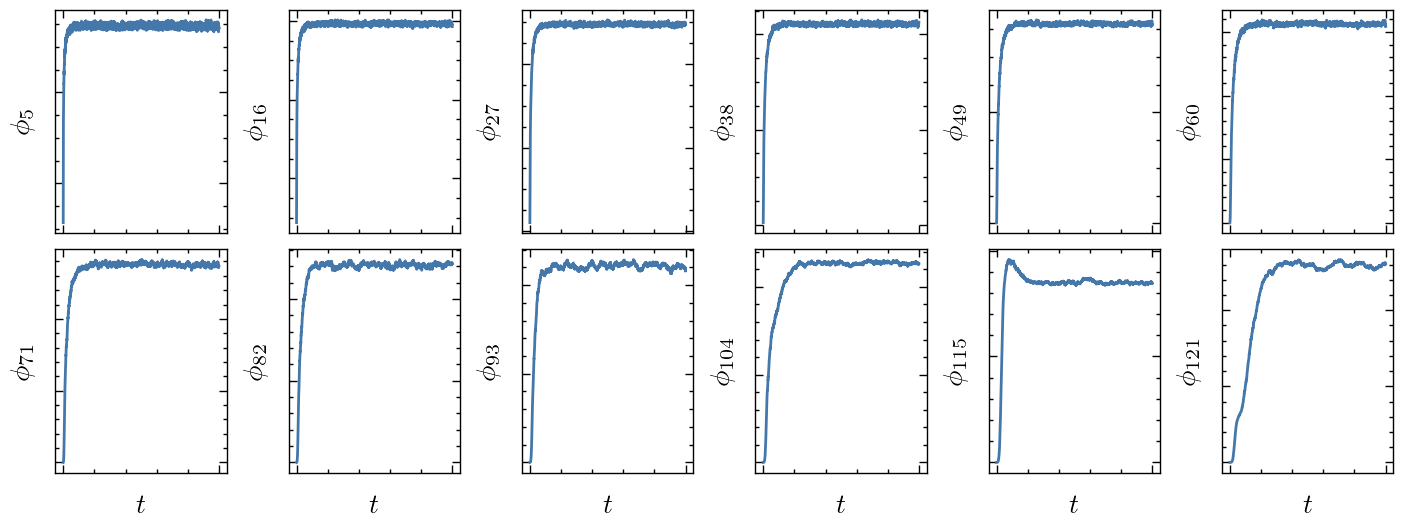

In [235]:
i_np    = [i*11+11//2 for i in range(11)] + [121]
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

for j, i in enumerate(i_np):

    ax  = fig.add_subplot(2,6,j+1)
    y   = states[f"{i}"].values*1000

    ax.plot(t_vals, y)
    ax.set_ylabel("$\phi_{"f'{i}'+"}$")
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.grid(False)

    if j > 5:
        ax.set_xlabel("$t$")
    
fig.savefig("../plots/network_states.svg", transparent=True)
fig.savefig("../plots/network_states.pdf", transparent=False)

---